In [1]:
import tensorflow as tf
print(tf.__version__)
import sys
print('Python version')
print(sys.version)


2.2.0
Python version
3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [2]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
#from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


from matplotlib import pyplot

import numpy as np
import pandas as pd

In [3]:
# load dataset
(trainX, trainy), (testX, testy) = cifar100.load_data(label_mode="fine")

In [4]:
trainX.shape, trainy.shape,testX.shape,testy.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [5]:
# Separate out three classes out of 100
def sep_class(trainx,trainy,y):
    class_x=[]
    for i in range(len(trainx)):
        if trainy[i]==y:
           #Normalise by 255
            class_x.append(trainx[i]/255)
        y_label=y*np.ones((len(class_x),1))
    return (np.array(class_x),np.array(y_label))

In [6]:
#Separate out three classes out of 100   
trainX0,trainy0=sep_class(trainX,trainy,0)
testX0,testy0=sep_class(testX,testy,0)

#Separate out one classes out of 100   
trainX1,trainy1=sep_class(trainX,trainy,1)
testX1,testy1=sep_class(testX,testy,1)

#Separate out 2 class out of 100   
trainX2,trainy2=sep_class(trainX,trainy,2)
testX2,testy2=sep_class(testX,testy,2)

# ----combining training and test data together---
dataX=np.concatenate((trainX0,testX0,trainX1,testX1,trainX2,testX2)) # concatenating both train and test togther
datay=np.concatenate((trainy0,testy0,trainy1,testy1,trainy2,testy2))

# training samples
dataXshuffle=list(zip(dataX,datay))
np.random.shuffle(dataXshuffle)

dataXn,datayn=zip(*dataXshuffle)
dataXn=np.array(dataXn)
datayn=np.array(datayn)
dataXn.shape, datayn.shape

((1800, 32, 32, 3), (1800, 1))

In [7]:
#split data into training and test set
trainX,testX,trainy,testy = train_test_split(dataXn,datayn,test_size=0.1,random_state=42)
print(trainX.shape,testX.shape, trainy.shape, testy.shape)

(1620, 32, 32, 3) (180, 32, 32, 3) (1620, 1) (180, 1)


In [8]:
trainy=keras.utils.to_categorical(trainy,3)
testy=keras.utils.to_categorical(testy,3)


In [9]:
print(testy.shape, " : ", trainy.shape)

(180, 3)  :  (1620, 3)


In [10]:

test_batched = tf.data.Dataset.from_tensor_slices((list(testX),list(testy))).batch(len(testy))


In [11]:
print(test_batched)

<BatchDataset shapes: ((None, 32, 32, 3), (None, 3)), types: (tf.float64, tf.float32)>


In [12]:
def create_clients(image_list, label_list, num_clients=3, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    np.random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))
    #clientN={'client_names[0]': shards[0]}
    #return clientN
    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [13]:
#create clients
clients = create_clients(trainX,trainy, num_clients=3, initial='client')
clients.keys()

dict_keys(['client_1', 'client_2', 'client_3'])

In [14]:
for key, value in clients.items():
    print('key:',key,len(value))

key: client_1 540
key: client_2 540
key: client_3 540


In [15]:
def batch_data(data_shard, bs=16):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)




In [16]:
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

In [17]:
clients_batched.items()

dict_items([('client_1', <BatchDataset shapes: ((None, 32, 32, 3), (None, 3)), types: (tf.float64, tf.float32)>), ('client_2', <BatchDataset shapes: ((None, 32, 32, 3), (None, 3)), types: (tf.float64, tf.float32)>), ('client_3', <BatchDataset shapes: ((None, 32, 32, 3), (None, 3)), types: (tf.float64, tf.float32)>)])

In [18]:
clients_batched['client_1'].element_spec


(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))

In [19]:
class SimpleKeras:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        #model._name = 'Name0_1'
        model.add(Conv2D(16,kernel_size=(2,2),strides=(1,1),
                    padding="same", input_shape=(32,32,3),activation='relu',name='Conv1'))
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),name='Pool1'))
        model.add(Conv2D(32,kernel_size=(2,2),strides=(1,1),
                    padding="same", activation='relu',name='Conv2'))
    
        model.add(Flatten()) 
        model.add(Dense(250,activation='relu',name='Dense1'))
        model.add(Dense(100, activation ='relu',name='Dense2')) # 3 classes
        model.add(Dense(50, activation ='relu',name='Dense3'))  
        model.add(Dense(3, activation ='softmax',name='Output'))
        #model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
       # model.summary()    
        return model


In [20]:

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    #print(global_count)
    #print(local_count)
    return local_count/global_count



In [21]:

def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


In [22]:

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad


In [23]:
def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [24]:
#initialize global model
smlp_global = SimpleKeras()
global_model = smlp_global.build((32,32,3),3)
comms_round = 1
modelList = {}
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    #print(len(global_weights))
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    #print(client_names)
    np.random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleKeras()
        local_model = smlp_local.build((32,32,3),3)
    
        local_model.compile(loss='categorical_crossentropy', 
                      optimizer=Adam(lr=0.0001), 
                      metrics=['accuracy'])
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        #modelList.append(local_model)
        modelList[client] = local_model
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

comm_round: 0 | global_acc: 66.111% | global_loss: 1.019399881362915


In [25]:
modelList

{'client_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f35c1ab42b0>,
 'client_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f35be2cfb38>,
 'client_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f35af7f02e8>}

# Sequence of events for the paper
- use 3 trained models as proposed models from clients
- Utilize 3 peers with independent datasets to evaluate the proposed models
- Choose 2 of the best proposed models
- Aggregate the chosen models into the global model

# Establish the datasets of the 3 peers
- each peer is certified and trusted to work on the distributed system
- each peer holds their own dataset and tests new submodels submitted to the system by clients

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 3 client models (captured in modelList)

#--------------------------------------------------------------------
# Generate 3 independent Test data sets for the peers

origTrainX,origTestX,origTrainy,origTesty = train_test_split(dataXn,datayn,test_size=0.1,random_state=42)

o_trainy=keras.utils.to_categorical(origTrainy,3)
o_testy=keras.utils.to_categorical(origTesty,3)

## array_split divides the the array into the specified number of sarrays
## this results in an array of arrays
splitTestX = np.array_split(origTestX, 3)
splitTestY = np.array_split(o_testy, 3)

p_testX0 = splitTestX[0][:50]
p_testy0 = splitTestY[0][:50]
 
p_testX1 = splitTestX[1][:50]
p_testy1 = splitTestY[1][:50]

p_testX2 = splitTestX[2][:50]
p_testy2 = splitTestY[2][:50]


# Have the three peers test the proposed models and print the results
- After the submodels are submitted they are stored in a shared drive accesible by the peers
- The peers grab a copy of the model and then test its accuracy to their own datasets
- The peers would then transact the results to the smart contract
- This is done until all peers have scored the accuracy for the submodels

comm_round: 1 | global_acc: 46.000% | global_loss: 1.0169970989227295
comm_round: 1 | global_acc: 68.000% | global_loss: 1.0148504972457886
comm_round: 1 | global_acc: 62.000% | global_loss: 1.0343014001846313
comm_round: 1 | global_acc: 44.000% | global_loss: 1.0258904695510864
comm_round: 1 | global_acc: 62.000% | global_loss: 1.0054504871368408
comm_round: 1 | global_acc: 70.000% | global_loss: 0.9993771314620972
comm_round: 1 | global_acc: 64.000% | global_loss: 1.001991629600525
comm_round: 1 | global_acc: 68.000% | global_loss: 1.0183180570602417
comm_round: 1 | global_acc: 58.000% | global_loss: 1.028354287147522


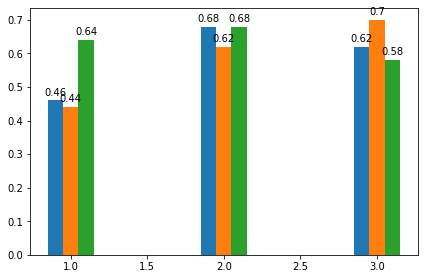

client_1  :  0.5133333333333333
client_2  :  0.66
client_3  :  0.6333333333333333


In [27]:
#--------------------------------------------------------------------
# Use peer models to report accuracy of the 2 client proposed models
modelAvgs = {}

peer0_acc = {}
peer1_acc = {}
peer2_acc = {}

#peer0_acc = []
#peer0_acc.append(test_model(p_testX0, p_testy0, modelList['client_1'], 1)[0])
#peer0_acc.append(test_model(p_testX0, p_testy0, modelList['client_2'], 1)[0])
#peer0_acc.append(test_model(p_testX0, p_testy0, modelList['client_3'], 1)[0])
peer0_acc['client_1']=test_model(p_testX0, p_testy0, modelList['client_1'], 1)[0]
peer0_acc['client_2']=test_model(p_testX0, p_testy0, modelList['client_2'], 1)[0]
peer0_acc['client_3']=test_model(p_testX0, p_testy0, modelList['client_3'], 1)[0]

#peer1_acc = []
#peer1_acc.append(test_model(p_testX1, p_testy1, modelList['client_1'], 1)[0])
#peer1_acc.append(test_model(p_testX1, p_testy1, modelList['client_2'], 1)[0])
#peer1_acc.append(test_model(p_testX1, p_testy1, modelList['client_3'], 1)[0])
peer1_acc['client_1']=test_model(p_testX1, p_testy1, modelList['client_1'], 1)[0]
peer1_acc['client_2']=test_model(p_testX1, p_testy1, modelList['client_2'], 1)[0]
peer1_acc['client_3']=test_model(p_testX1, p_testy1, modelList['client_3'], 1)[0]

#peer2_acc = []
#peer2_acc.append(test_model(p_testX2, p_testy2, modelList['client_1'], 1)[0])
#peer2_acc.append(test_model(p_testX2, p_testy2, modelList['client_2'], 1)[0])
#peer2_acc.append(test_model(p_testX2, p_testy2, modelList['client_3'], 1)[0])
peer2_acc['client_1']=test_model(p_testX2, p_testy2, modelList['client_1'], 1)[0]
peer2_acc['client_2']=test_model(p_testX2, p_testy2, modelList['client_2'], 1)[0]
peer2_acc['client_3']=test_model(p_testX2, p_testy2, modelList['client_3'], 1)[0]

# The smart contract will get the average and transact each peers result along with the average
for client in modelList:
    modelAvgs[client]=(peer0_acc[client]+peer1_acc[client]+peer2_acc[client])/3


x = np.array([1,2,3])
width = 0.1

fig, ax = plt.subplots()
peer0 = ax.bar(x-width, list(peer0_acc.values()), width, label='Peer0')
peer1 = ax.bar(x, list(peer1_acc.values()), width, label='Peer1')
peer2 = ax.bar(x+width, list(peer2_acc.values()), width, label='Peer2')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(peer0)
autolabel(peer1)
autolabel(peer2)
        
fig.tight_layout()
plt.show()

for i in modelAvgs:
    print(i, " : ", modelAvgs[i])


# Choose the best models and aggregate them into the global model
- In this example the top 2 out of three are chosen and then aggregated
- The top models should be chosen based on the criteria specified in the paper
- The top models are then combined/aggregated by a chosen peer
- A hash of the model and its accuracy are transacted to the global model blockchain 

In [28]:
#--------------------------------------------------------------------
# Combine client models into global model
global_model = smlp_global.build((32,32,3),3)
comms_round = 1

top2 = sorted(modelAvgs.values(), reverse=True)[:2]
print("Top 2 ranked models ", " : ", top2)

for client in modelList:    
    if modelAvgs[client] in top2:
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(modelList[client].get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        #clear session to free memory after each communication round
        K.clear_session()

#to get the average over all the local model, we simply take the sum of the scaled weights
average_weights = sum_scaled_weights(scaled_local_weight_list)

#update global model 
global_model.set_weights(average_weights)



Top 2 ranked models   :  [0.66, 0.6333333333333333]


In [29]:
#--------------------------------------------------------------------
# Report global model accuracy

#test global model and print out metrics after each communications round
for(X_test, Y_test) in test_batched:
    global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

comm_round: 0 | global_acc: 69.444% | global_loss: 0.8578529953956604


In [30]:
#test_model(p_testX1, p_testy1, modelList['client_1'], 1)[0]

## Handle training data load/save
np.save('testX2.npy', p_testX1, allow_pickle=True)
X0 = np.load('testX2.npy', allow_pickle=True)

np.save('testy2.npy', p_testy1, allow_pickle=True)
y0 = np.load('testy2.npy', allow_pickle=True)

print(len(X0))
print(len(y0))

## Handling model load/model save
modelList['client_1'].save('fed1_recognition.model')
print(test_model(X0, y0, modelList['client_2'], 1))
#client1 = model = tf.keras.models.load_model('fed1_recognition.model')
#print(client1)

50
50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: fed1_recognition.model/assets
comm_round: 1 | global_acc: 62.000% | global_loss: 1.0054504871368408
(0.62, <tf.Tensor: shape=(), dtype=float32, numpy=1.0054505>)
